# 1.数据导入与可视化

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
data = pd.read_excel(r'C:\2RR\ckd.xlsx') # 导入数据

In [3]:
data

,sg,wbcc,sc,grf,bu,sod,hemo,rbcc,pot,age,bp_Diastolic,rbc,class
0,3,2,0,9,0,5,0,1,1,0,0,0,1
1,1,4,0,9,0,4,0,1,0,0,0,0,1
2,1,5,0,5,1,4,0,1,0,0,0,1,1
3,1,2,0,5,0,4,0,1,0,0,1,0,1
4,2,2,0,5,0,4,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,3,2,0,1,0,5,0,1,0,9,1,0,1
195,3,2,0,0,1,4,0,1,0,9,0,0,1
196,4,2,0,2,0,6,1,2,0,9,1,0,0
197,4,1,0,4,0,5,1,1,0,9,1,0,0


## 数据可视化

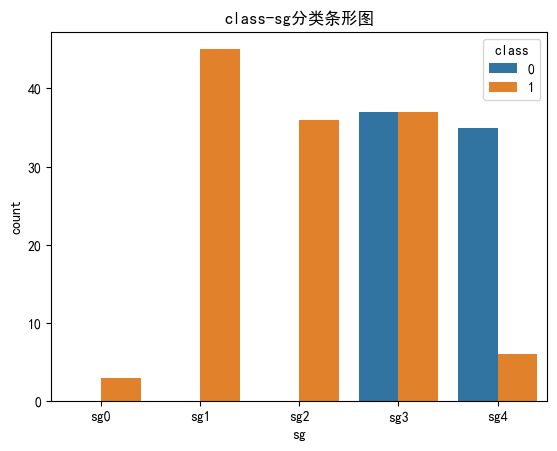

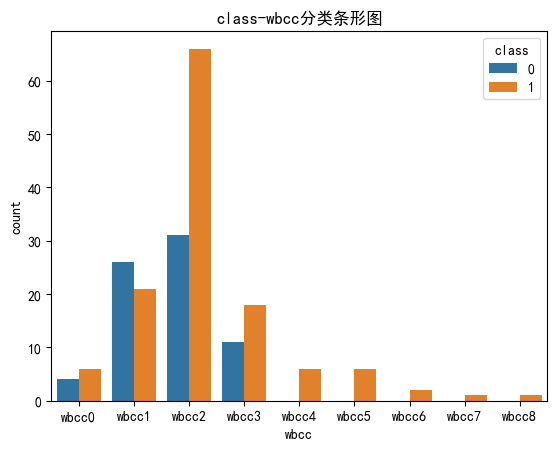

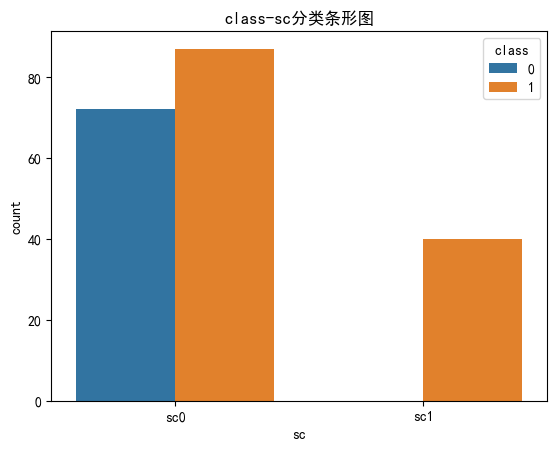

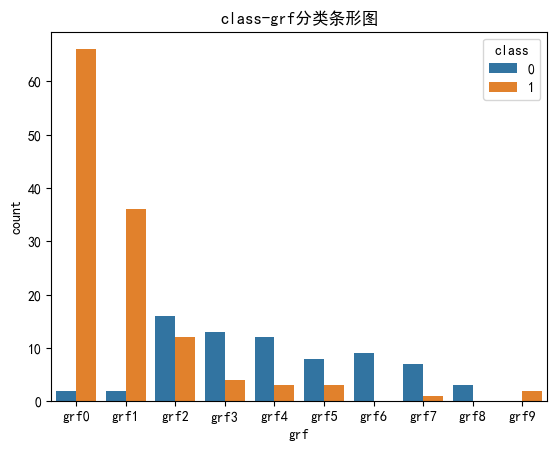

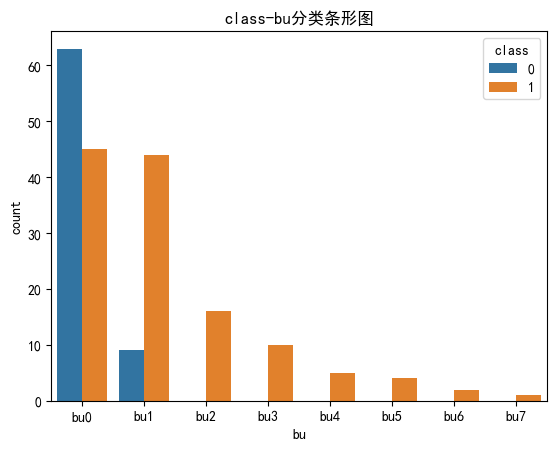

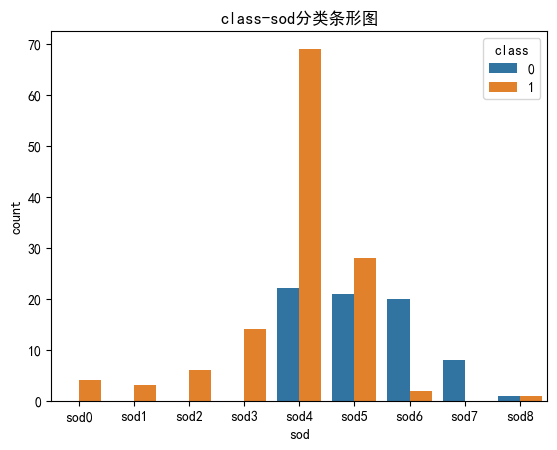

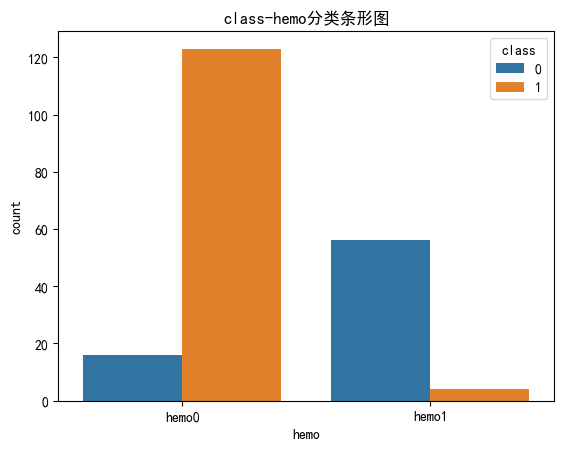

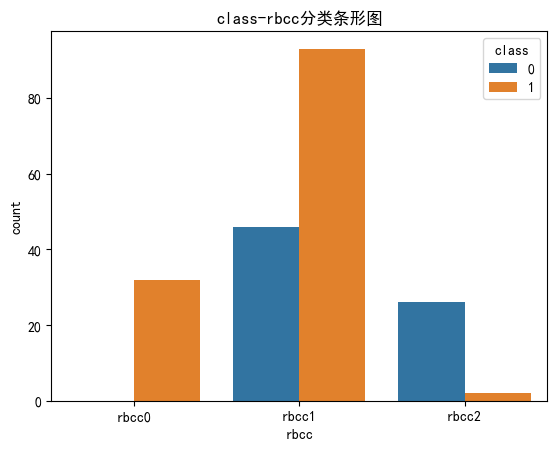

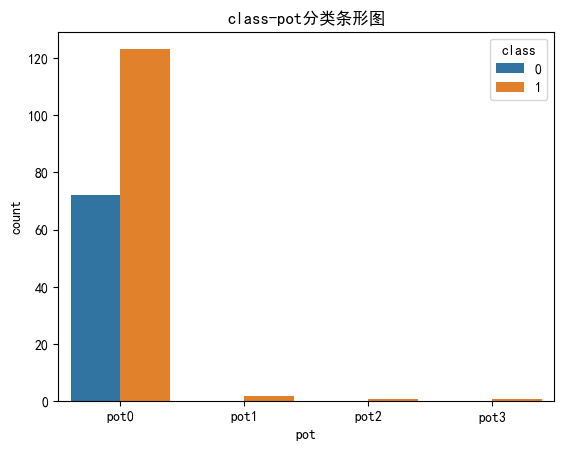

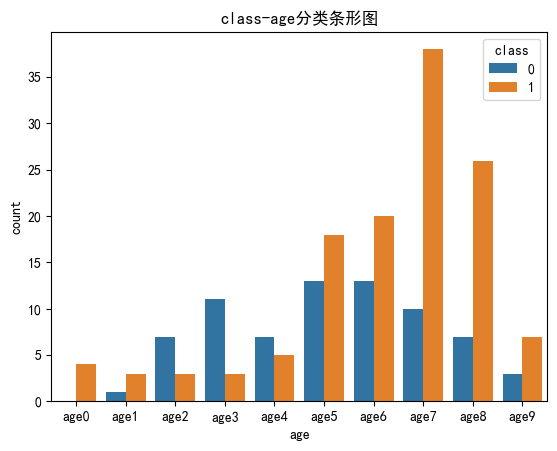

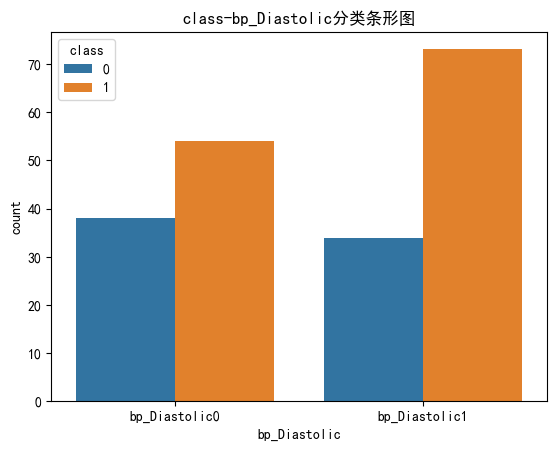

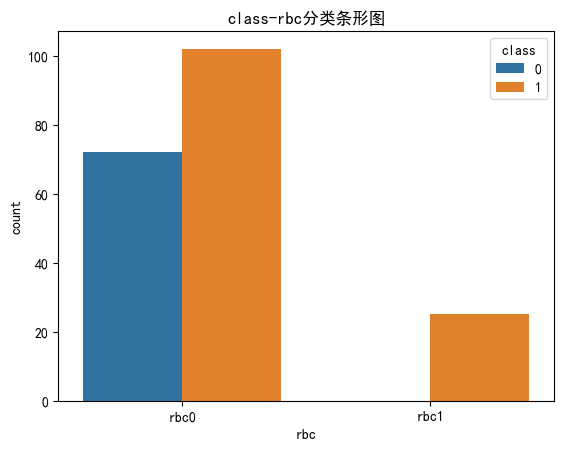

In [4]:
columns_name = list(data.columns).copy()
columns_name.remove('class')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

for col in columns_name:
    
    df = data[[col,'class']]
    pd.crosstab(index=df[col], columns=df['class'], )
    a = np.array(pd.crosstab(index=df[col], columns=df['class']))
    stats.chi2_contingency(a)
    
    sns.countplot(x=df[col], hue=df['class'])
    k = len(set(list(data[col])))
    xlabel = list(map( lambda x : col + str(x), list(range(k))))
    plt.xticks(list(range(k)),  xlabel) 
    plt.title("class-{}分类条形图".format(col))
    plt.show()

# 2.模型建立与分析

In [5]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score # 划分为训练集和测试集
from sklearn.linear_model import LogisticRegression # 从sklearn中导入逻辑回归模型
from sklearn import metrics # 从sklearn中导入评估模型效果的函数
from sklearn.ensemble import RandomForestRegressor # 导入随机森林回归器

## 2.1定义类包括建模的函数

In [6]:
class CKDmodel:
    def set_data(self, data):
        self.data = data
        self.target = data['class']
        self.features = data.drop(columns = 'class', axis = 1)   

    def get_data(self):
        return self.data
    
    def sample_split(self, rate, seednum):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.features, self.target, test_size = rate, random_state = seednum)
        return self.x_train,self.y_train
    
    def sample_reconcat(self):
        self.xy_train = self.x_train.copy() 
        self.xy_train['class'] = self.y_train  #将训练样本重新拼接 用于逐步回归的输入    
        return self.xy_train
    
    def LRfit(self):
        self.clf = LogisticRegression(random_state=0, solver='lbfgs') 
        return self.clf.fit(self.x_train, self.y_train) # 训练模型
    
    def LROutcome(self):
        print('The weight of Logistic Regression:',np.around(self.clf.coef_, 3)) ## 查看其对应的w
        print('The intercept(w0) of Logistic Regression:',np.around(self.clf.intercept_, 3)) ## 查看其对应的w0
        
    # 模型预测结果    
    def LRpredict(self):
        self.train_predict = self.clf.predict(self.x_train)
        self.test_predict = self.clf.predict(self.x_test)
        
    # 模型准确率    
    def LRaccur(self):
        print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(self.y_train,self.train_predict),'with train dataset')
        print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(self.y_test,self.test_predict),'with test dataset')  
        
    # 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)    
    def LRconfusion_matrix(self):
        self.confusion_matrix_result = metrics.confusion_matrix(self.test_predict,self.y_test)
        print('The confusion matrix result:\n',self.confusion_matrix_result)        
        
    def LRcmatrix_plot(self,modelname):
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.confusion_matrix_result, annot=True, cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix plot of Model{}'.format(modelname))
        plt.show()
    
    def RFfit(self,n_estimators,criterion):
        #利用随机森林进行训练
        self.forest = RandomForestRegressor(
            n_estimators=n_estimators,
            criterion=criterion,
            random_state=1,
            n_jobs=-1)
        return self.forest.fit(self.x_train, self.y_train)
    
    def RFscore(self):
        self.score = self.forest.score(self.x_test, self.y_test) # 返回值为决定系数R^2
        self.result = self.forest.predict(self.x_test)

        plt.figure()
        plt.plot(np.arange(len(self.y_test)), self.y_test, "go-", label="True value")
        plt.plot(np.arange(len(self.result)), self.result, "ro-", label="Predict value")
        plt.title(f"RandomForest---score:{self.score}")
        plt.legend(loc="best")
        return self.score
    
    def RF_feaimp(self):  # 下面对训练好的随机森林，完成重要性评估
        self.random_forest_importance=list(self.forest.feature_importances_)
        self.random_forest_feature_importance=[(feature,round(importance,8)) 
                                  for feature, importance in zip(list(self.x_train),self.random_forest_importance)]
        self.random_forest_feature_importance=sorted(self.random_forest_feature_importance,key=lambda x:x[1],reverse=True)
        plt.figure(3)
        plt.clf()
        self.importance_plot_x_values=list(range(len(self.random_forest_importance)))
        plt.bar(self.importance_plot_x_values,self.random_forest_importance,orientation='vertical')
        plt.xticks(self.importance_plot_x_values,list(self.x_train),rotation='vertical')
        plt.xlabel('Variable')
        plt.ylabel('Importance')
        plt.title('Variable Importances') 

## 2.2 Logistic回归 

In [7]:
# logistic回归参数的设定
rate = 0.3
seed = 48

2.2.1原始模型

The weight of Logistic Regression: [[-2.253  0.44   0.323 -0.363  0.531 -0.689 -1.896 -1.299  0.674 -0.096
   0.183  0.178]]
The intercept(w0) of Logistic Regression: [12.491]
The accuracy of the Logistic Regression is: 0.9856115107913669 with train dataset
The accuracy of the Logistic Regression is: 0.9166666666666666 with test dataset
The confusion matrix result:
 [[19  4]
 [ 1 36]]


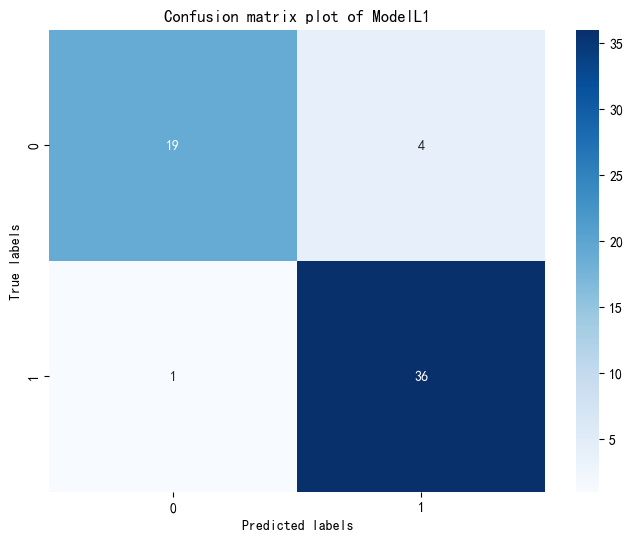

In [8]:
ckdLR = CKDmodel() # 类的实例化

ckdLR.set_data(data)
ckdLR.sample_split(rate, seed)
ckdLR.LRfit()
ckdLR.LROutcome()
ckdLR.LRpredict()
ckdLR.LRaccur() #利用accuracy（准确度）评估模型效果
ckdLR.LRconfusion_matrix() # 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
ckdLR.LRcmatrix_plot(modelname='L1') #可视化

2.2.2 逐步回归筛选变量后再次进行logistic回归 

In [9]:
afterstepwiseLR = CKDmodel() # 类的实例化

afterstepwiseLR.set_data(data)
afterstepwiseLR.sample_split(rate, seed)
xy_train = afterstepwiseLR.sample_reconcat() # 拼接训练集数据

In [10]:
# 逐步回归筛选变量
import os
import toad

after_stepwise_data = toad.selection.stepwise(xy_train,
                                    target = 'class',
                                     estimator='lr', 
                                     direction = 'both', 
                                     criterion = 'aic'
                                     )

The weight of Logistic Regression: [[-2.13   0.426  0.58   0.875 -1.953 -1.413 -0.     0.084 -0.064  0.283]]
The intercept(w0) of Logistic Regression: [7.075]
The accuracy of the Logistic Regression is: 0.979381443298969 with train dataset
The accuracy of the Logistic Regression is: 0.9761904761904762 with test dataset
The confusion matrix result:
 [[16  0]
 [ 1 25]]


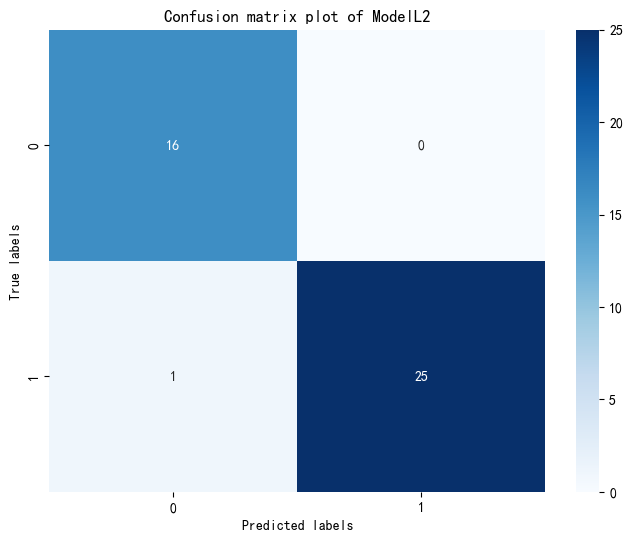

In [11]:
afterstepwiseLR.set_data(after_stepwise_data)
afterstepwiseLR.sample_split(rate, seed)
afterstepwiseLR.LRfit()
afterstepwiseLR.LROutcome()
afterstepwiseLR.LRpredict()
afterstepwiseLR.LRaccur() #利用accuracy（准确度）评估模型效果
afterstepwiseLR.LRconfusion_matrix() # 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
afterstepwiseLR.LRcmatrix_plot(modelname = 'L2') #可视化

## 2.3 随机森林

In [12]:
# 随机森林参数
n_estimators = 100
criterion = 'absolute_error' # 四个可选参数'squared_error', 'absolute_error', 'poisson', 'friedman_mse' 通过对比发现'absolute_error'得分最高

In [13]:
ckdRF = CKDmodel() # 类的实例化

ckdRF.set_data(data)
x_train,y_train = ckdRF.sample_split(rate, seed)
RF0 = ckdRF.RFfit(n_estimators,criterion)
score = cross_val_score(RF0, x_train, y_train, cv=10).mean()
print(score) # 选择criterion的最优参数的得分

0.8428829404761903


定义调参函数

In [14]:
def Tuning_Hyperparameters(lower, upper, step, x_train, y_train, parameter_info):
    ScoreAll = []
    par_name = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
    for i in range(lower, upper, step):
        if len(parameter_info) == 0:
            DT = RandomForestRegressor(n_estimators=i, random_state=1, criterion = 'absolute_error',n_jobs=-1)
        elif len(parameter_info) == 1:
            DT = RandomForestRegressor(n_estimators=parameter_info[0], max_depth=i, random_state=1, criterion = 'absolute_error',n_jobs=-1)
        elif len(parameter_info) == 2:
            DT = RandomForestRegressor(n_estimators=parameter_info[0], 
                                       max_depth=parameter_info[1],
                                       min_samples_split = i,
                                       random_state=1, criterion = 'absolute_error',n_jobs=-1)
        elif len(parameter_info) == 3:
            DT = RandomForestRegressor(n_estimators=parameter_info[0], 
                                       max_depth=parameter_info[1],
                                       min_samples_split=parameter_info[2],
                                       min_samples_leaf = i,
                                       random_state=1, criterion = 'absolute_error',n_jobs=-1)
            
        # 若min_samples_split输入的参数为1，自动捕获异常，并终止函数。
        try:
            score = cross_val_score(DT,x_train,y_train,cv=10).mean()
        except ValueError as e:
            print('捕获到异常',e,"The 'min_samples_split' parameter of RandomForestRegressor must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.") 
            return
        ScoreAll.append([i,score])
    ScoreAll = np.array(ScoreAll)

    max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
    print("{}最优参数以及最高得分:{}".format(par_name[len(parameter_info)], ScoreAll[max_score]))  
    plt.figure(figsize=[20,5])
    plt.plot(ScoreAll[:,0],ScoreAll[:,1])
    plt.xlabel(par_name[len(parameter_info)])
    plt.ylabel('score')
    plt.show()       

n_estimators最优参数以及最高得分:[330.           0.84834967]


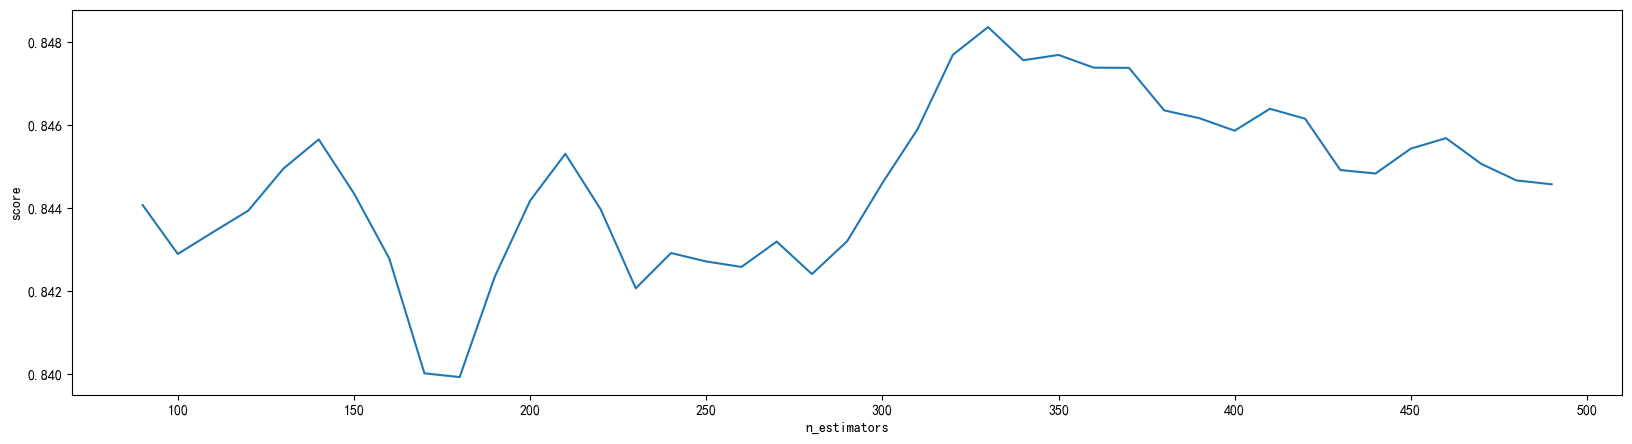

In [15]:
## 调n_estimators参数
parameter_info = []
Tuning_Hyperparameters(90, 500, 10, x_train, y_train, parameter_info)

max_depth最优参数以及最高得分:[5.         0.84910977]


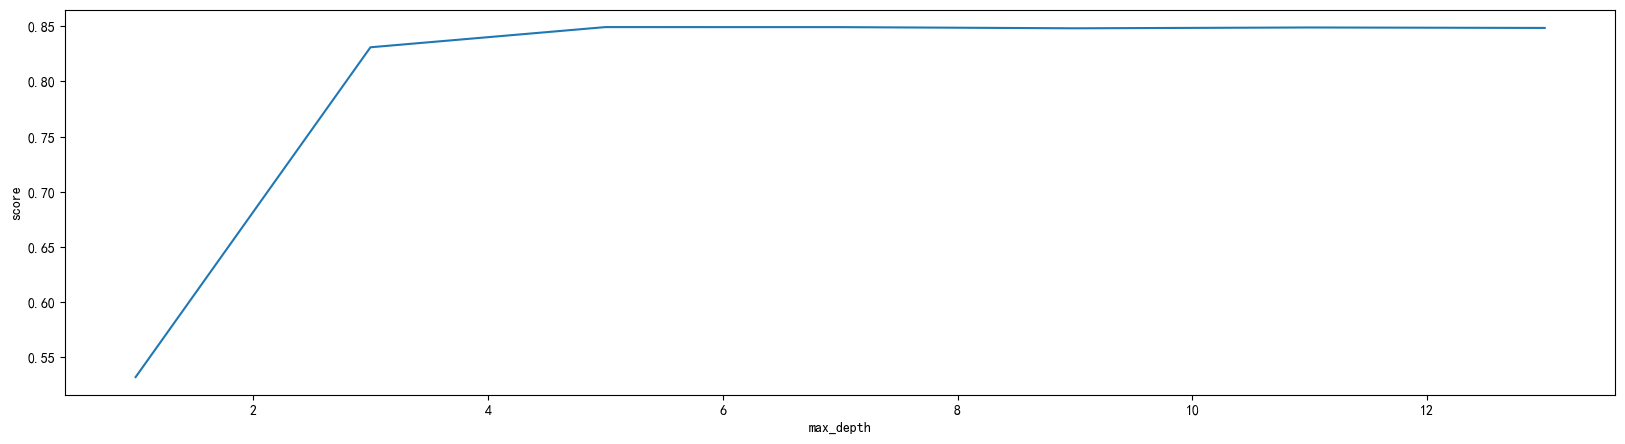

In [16]:
## 粗调max_depth参数
parameter_info = [330]
Tuning_Hyperparameters(1, 15, 2, x_train, y_train, parameter_info)

min_samples_split最优参数以及最高得分:[2.         0.84910977]


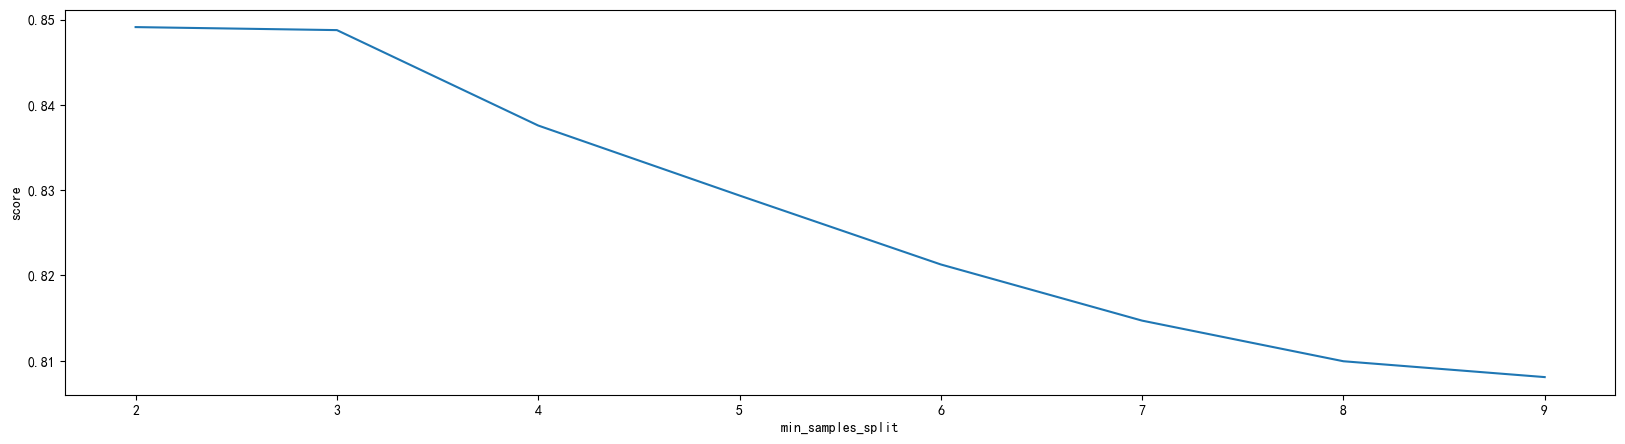

In [17]:
## 调min_samples_split参数
parameter_info = [330, 5]
Tuning_Hyperparameters(2, 10 ,1 , x_train, y_train, parameter_info) # lower不能取1

min_samples_leaf最优参数以及最高得分:[1.         0.84910977]


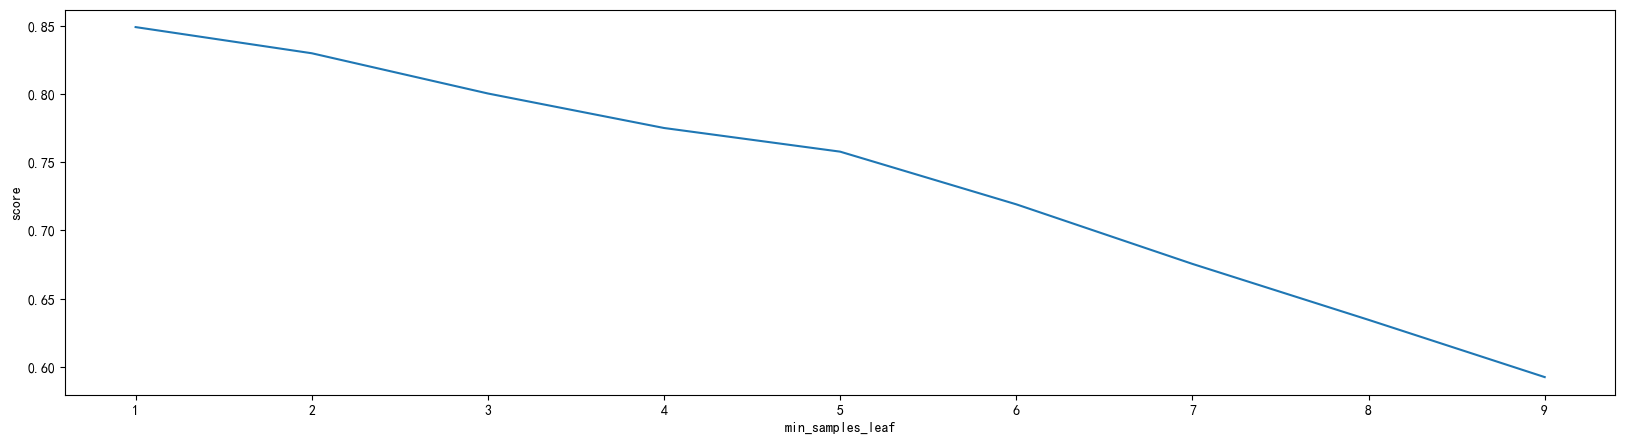

In [18]:
## 调min_samples_leaf参数
parameter_info = [330, 5, 2]
Tuning_Hyperparameters(1, 10 ,1 , x_train, y_train, parameter_info)

修改原类的方法

In [19]:
 # 修改原模型参数为调整后的参数
class CKDrf(CKDmodel):
    def RFfit(self):
       
        self.forest = RandomForestRegressor(
            n_estimators=330,
            max_depth=5,
            min_samples_split=2,
            min_samples_leaf =1,
            criterion='absolute_error',
            random_state=1,
            n_jobs=-1)
        return self.forest.fit(self.x_train, self.y_train) 

0.8340072314049587

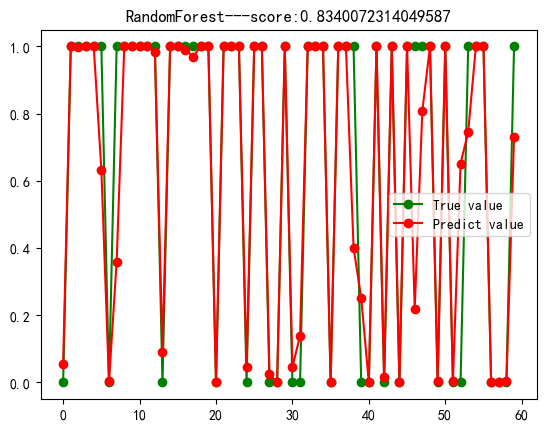

In [20]:
ckdRF1 = CKDrf()
ckdRF1.set_data(data)
ckdRF1.sample_split(rate, seed)
ckdRF1.RFfit()
ckdRF1.RFscore()

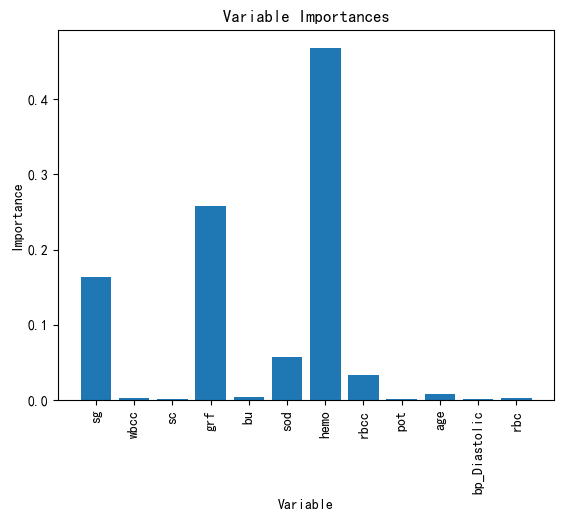

In [21]:
ckdRF1.RF_feaimp() ## RF回归特征变量 重要性分析可视化